# Reproduce CheXNet: Explore Predictions

## Import other modules and pandas

In [29]:
import visualize_prediction as V

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

#suppress pytorch warnings about source code changes
import warnings
warnings.filterwarnings('ignore')

## Settings for review
We can examine individual results in more detail, seeing probabilities of disease for test images. 

We get you started with a small number of the images from the large NIH dataset. 

To explore the full dataset, [download images from NIH (large, ~40gb compressed)](https://nihcc.app.box.com/v/ChestXray-NIHCC), extract all tar.gz files to a single folder, place that path  below and set STARTER_IMAGES=False

In [30]:
STARTER_IMAGES  = True
PATH_TO_IMAGES  = "starter_images/"
LABELS_FILENAME = "nih_labels.csv"

#STARTER_IMAGES=False
#PATH_TO_IMAGES = "your path to NIH data here"
#LABELS_FILENAME = "nih_labels.csv"

Load pretrained model (part of cloned repo; should not need to change path unless you want to point to one you retrained)

In [31]:
PATH_TO_MODEL = "pretrained/checkpoint"

Pick the finding you want to see positive examples of:

LABEL can be set to any of:
- Atelectasis
- Cardiomegaly
- Consolidation
- Edema
- Effusion
- Emphysema
- Fibrosis
- Hernia
- Infiltration
- Mass
- Nodule
- Pleural_Thickening
- Pneumonia
- Pneumothorax


In [32]:
LABEL="Pneumonia"

It's more interesting when initially exploring to see cases positive for pathology of interest:

In [33]:
POSITIVE_FINDINGS_ONLY=True

## Load data

This loads up dataloader and model (note: only test images not used for model training are loaded).

In [34]:
dataloader,model= V.load_data(PATH_TO_IMAGES,LABEL,PATH_TO_MODEL,POSITIVE_FINDINGS_ONLY,STARTER_IMAGES,LABELS_FILENAME)
print("Cases for review:")
print(len(dataloader))

Cases for review:
30


## Examine individual cases

To explore, run code below to see a random case positive for your selected finding, a heatmap indicating the most influential regions of the image, and the model's estimated probabilities for findings. For many diagnoses, you can see that the model uses features outside the expected region to calibrate its predictions -- [you can read my discussion about this here](https://medium.com/@jrzech/what-are-radiological-deep-learning-models-actually-learning-f97a546c5b98).

Please note that:
1) the NIH dataset was noisily labeled by automatically extracting labels from text reports written by radiologists, as described in paper [here](https://arxiv.org/pdf/1705.02315.pdf) and analyzed [here](https://lukeoakdenrayner.wordpress.com/2017/12/18/the-chestxray14-dataset-problems/), so we should not be surprised to see inaccuracies in the provided ground truth labels 
2) high AUCs can be achieved even if many positive cases are assigned absolutely low probabilities of disease, as AUC depends on the relative ranking of probabilities between cases. 

You can run the below cell repeatedly to see different examples:

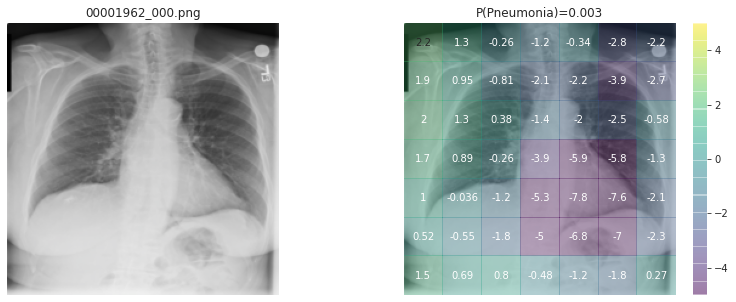

,Predicted Probability,Ground Truth
Finding,,
Atelectasis,0.079,True
Infiltration,0.057,False
Nodule,0.027,False
Pleural_Thickening,0.022,False
Cardiomegaly,0.015,False
Emphysema,0.008,False
Fibrosis,0.008,False
Consolidation,0.006,False
Effusion,0.005,False


In [39]:
preds, raw_cam, cxr = V.show_next(dataloader,model, LABEL)
preds

In [8]:
POSITIVE_FINDINGS_ONLY=False

dataloader,model= V.load_data(PATH_TO_IMAGES,LABEL,PATH_TO_MODEL,POSITIVE_FINDINGS_ONLY,STARTER_IMAGES,LABELS_FILENAME)
print("Cases for review:")
print(len(dataloader))

d = []
for indx in range(1,len(dataloader)):
    print(indx)
    try:
        preds=V.show_next(dataloader,model, LABEL, do_plots = False)
        d.append(
        {
            'preds': float(preds[preds.index == 'Pneumonia']["Predicted Probability"][0]),
            'gt': preds[preds.index == 'Pneumonia']["Ground Truth"][0]
        }
        )
    except:
        print("Sample {} not available or compatible".format(indx))

Cases for review:
621
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
27

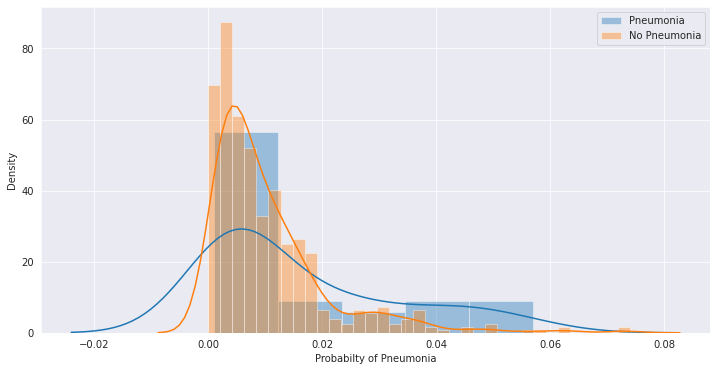

In [40]:
sns.set_style("darkgrid")

predictions = pd.DataFrame(d)

plt.figure(figsize=(12,6))
sns.distplot(predictions[predictions['gt']==True].preds, label = LABEL)
sns.distplot(predictions[predictions['gt']==False].preds, label = 'No '+ LABEL)
plt.legend()
plt.ylabel('Density')
plt.xlabel('Probabilty of Pneumonia')
plt.show()

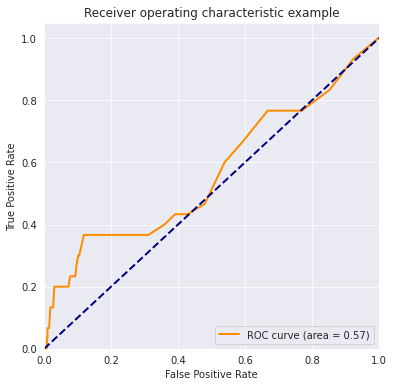

In [10]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = metrics.roc_curve(predictions['gt'], predictions['preds'])
# print(thresholds)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Create label file for covid cases

In [11]:
feats = ['Image Index',
 'Follow-up #',
 'Patient ID',
 'Patient Age',
 'Patient Gender',
 'View Position',
 'Cardiomegaly',
 'Emphysema',
 'Effusion',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Atelectasis',
 'Pneumothorax',
 'Pleural_Thickening',
 'Pneumonia',
 'Fibrosis',
 'Edema',
 'Consolidation',
 'fold',
 'finding']

In [12]:
df1 = pd.read_csv("../covid-chestxray-dataset/metadata.csv").rename(columns={"patientid": "Patient ID",
                                                                            "sex": "Patient Gender",
                                                                            "age": "Patient Age",
                                                                            "filename":"Image Index",
                                                                            "view":"View Position"
                                                                            })
df1["Follow-up #"] = 0
df1["fold"] = "test"
df1['Consolidation'] = 0.0
df1['Cardiomegaly']  = 0.0
df1['Emphysema'] = 0.0
df1['Effusion'] = 0.0
df1['Hernia'] = 0.0
df1['Infiltration'] = 0.0
df1['Hernia'] = 0.0
df1['Mass'] = 0.0
df1['Nodule'] = 0.0
df1['Atelectasis'] = 0.0
df1['Pneumothorax'] = 0.0
df1['Consolidation'] = 0.0
df1['Edema'] = 0.0
df1['Emphysema'] = 0.0
df1['Fibrosis'] = 0.0
df1['Pleural_Thickening'] = 0.0

# df1 = df1[(df1.finding != "No Finding")] 
df1 = df1[(df1.finding == "COVID-19") | (df1.finding == "COVID-19, ARDS")]
df1['Pneumonia'] = 1.0
# df1[(df1.finding == "No Finding")]['Pneumonia'] = 0.0
df1 = df1[feats]
df1.to_csv("covid_labels.csv", index=False)
df1.head()

,Image Index,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,Cardiomegaly,Emphysema,Effusion,Hernia,...,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation,fold,finding
0,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,0,2,65.0,M,PA,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,test,COVID-19
1,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,0,2,65.0,M,PA,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,test,COVID-19
2,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,0,2,65.0,M,PA,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,test,COVID-19
3,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,0,2,65.0,M,PA,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,test,COVID-19
4,nejmc2001573_f1a.jpeg,0,4,52.0,F,PA,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,test,COVID-19


In [13]:
df1.finding.value_counts()

COVID-19          230
COVID-19, ARDS     11
Name: finding, dtype: int64

## Examine individual COVID cases

In [14]:
# df = pd.read_csv("covid_labels.csv")
# df2 = pd.read_csv("nih_labels.csv")
# list(df),list(df2)

In [15]:
STARTER_IMAGES  = False
PATH_TO_IMAGES  = "covid_images/"
LABELS_FILENAME = "covid_labels.csv"

LABEL="Pneumonia"
POSITIVE_FINDINGS_ONLY=False


In [16]:
dataloader,model= V.load_data(PATH_TO_IMAGES,LABEL,PATH_TO_MODEL,POSITIVE_FINDINGS_ONLY,STARTER_IMAGES,LABELS_FILENAME)

print("Cases for review:")
print(len(dataloader))

Cases for review:
241


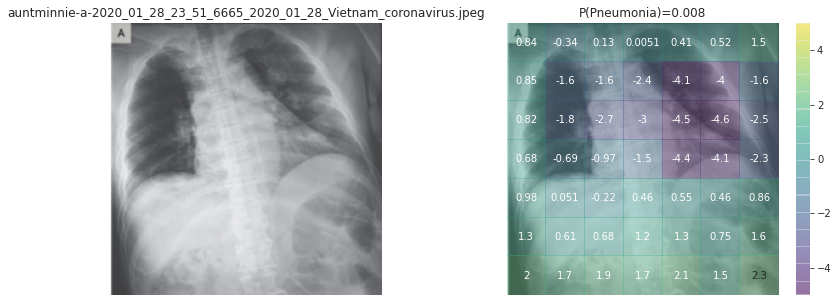

,Predicted Probability,Ground Truth
Finding,,
Nodule,0.202,False
Mass,0.146,False
Infiltration,0.120,False
Pleural_Thickening,0.057,False
Effusion,0.050,False
Pneumothorax,0.028,False
Consolidation,0.026,False
Atelectasis,0.021,False
Fibrosis,0.016,False


In [17]:
preds, raw_cam, cxr=V.show_next(dataloader,model, LABEL)
preds

In [18]:
POSITIVE_FINDINGS_ONLY=False

dataloader,model= V.load_data(PATH_TO_IMAGES,LABEL,PATH_TO_MODEL,POSITIVE_FINDINGS_ONLY,STARTER_IMAGES,LABELS_FILENAME)
print("Cases for review:")
print(len(dataloader))

d2 = []
for indx in range(1,len(dataloader)):
    print(indx)
    try:
        preds=V.show_next(dataloader,model, LABEL, do_plots = False)
        d2.append(
        {
            'preds': float(preds[preds.index == 'Pneumonia']["Predicted Probability"][0]),
            'gt': preds[preds.index == 'Pneumonia']["Ground Truth"][0]
        }
        )
    except:
        print("Sample {} not available or compatible".format(indx))
    

Cases for review:
241
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
Sample 42 not available or compatible
43
44
45
Sample 45 not available or compatible
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
Sample 169 not available or compatible
170
Sample 170 not available or compatible
171
Sample 171 not available or compatible
172
Sample 172 not available or compatible
173
Sample 173 not available or compatible
174
Sample 174 not available or compatible
175
Sample 175 not available or compatible
176
Sample 176 not available or compa

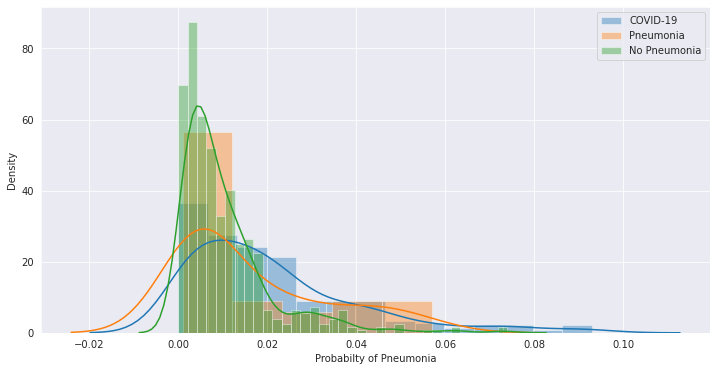

In [19]:
predictions2 = pd.DataFrame(d2)

plt.figure(figsize=(12,6))
sns.distplot(predictions2[predictions2['gt']==True].preds, label = 'COVID-19')
sns.distplot(predictions[predictions['gt']==True].preds, label = LABEL)
sns.distplot(predictions[predictions['gt']==False].preds, label = 'No '+ LABEL)
plt.legend()
plt.ylabel('Density')
plt.xlabel('Probabilty of Pneumonia')
plt.show()

## Make better overlay

In [20]:
dataloader,model= V.load_data(PATH_TO_IMAGES,LABEL,PATH_TO_MODEL,POSITIVE_FINDINGS_ONLY,STARTER_IMAGES,LABELS_FILENAME)



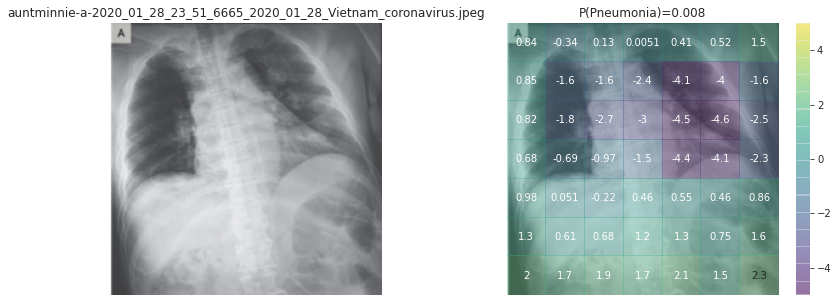

,Predicted Probability,Ground Truth
Finding,,
Nodule,0.202,False
Mass,0.146,False
Infiltration,0.120,False
Pleural_Thickening,0.057,False
Effusion,0.050,False
Pneumothorax,0.028,False
Consolidation,0.026,False
Atelectasis,0.021,False
Fibrosis,0.016,False


In [21]:
preds, raw_cam, cxr = V.show_next(dataloader,model, LABEL)
preds

In [22]:
np.max(cxr), cxr.shape

(0.9803922173976899, (224, 224, 3))

In [23]:
np.max(raw_cam), raw_cam.shape

(2.3108354178163775, (7, 7, 1))

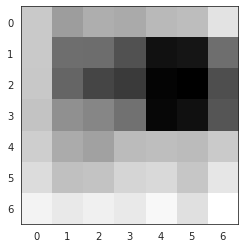

In [24]:
from scipy.interpolate import interp2d

sns.set_style("white")
plt.figure()
plt.imshow(np.squeeze(raw_cam), cmap='gray')#, cxr
plt.show()